# Preparing data

In [306]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


# Flowers Dataset and VGG Features

In [307]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [308]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
num_features

(3670, 4096) (3670,)


4096

In [309]:
type(f_all)

numpy.ndarray

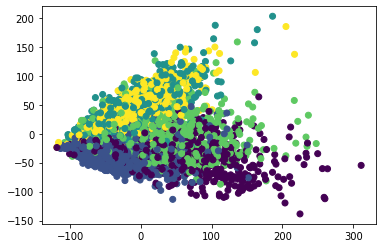

In [310]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

In [311]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')
        self.model.train()
        #self.model.eval()
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
        running_corrects = 0
        epoch_acc = 0
        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                optimizer.zero_grad()
                output = self(X_)
                loss = criterion(output, y_)
                loss.backward()
                optimizer.step()

        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        criterion = nn.NLLLoss()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        self.model.eval()
        dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        correct = 0
        total = 0
        acc = 0
        with torch.no_grad():
            for (X_, y_) in dataloader:
                output = self(X_)
                #loss = criterion(output, y_)
                #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(y_.view_as(pred)).sum().item()
                total += X_.shape[0]
                acc = correct / total

        print('Average accuracy is: {}'.format(acc))
     
        #raise NotImplementedError



# Autoencoder

In [312]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


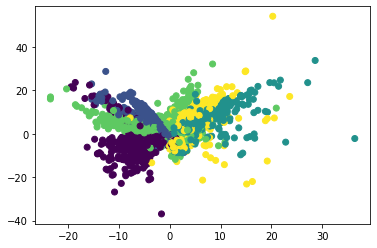

In [313]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

# TSNE

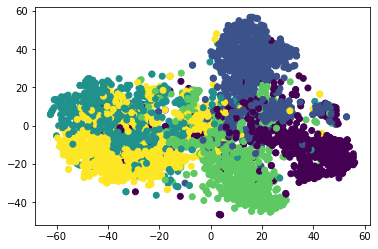

In [314]:

from sklearn.manifold import TSNE
f_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)



# Question 24

In [315]:
#pip install umap-learn

In [316]:
#pip install hdbscan --no-build-isolation --no-binary :all:

In [317]:
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.pipeline import Pipeline

svd = TruncatedSVD(n_components=50)
umap_ = umap.UMAP(metric='cosine', n_components=50)
umap_ = umap.UMAP(n_components=50)
auto =Autoencoder(50)

km = KMeans(n_clusters=5)
agg = AgglomerativeClustering(n_clusters=5)
hdbs = hdbscan.HDBSCAN(min_cluster_size=170, min_samples=5)


preprocessors = Pipeline(
[('none', None),('svd', svd),('umap', umap_),('auto', auto),]
)
clusterer1 = Pipeline([
("km", km,),]
)
clusterer2 = Pipeline([
("agg", agg,),]
)
clusterer3 = Pipeline([
("hdbs", hdbs,),]
)

lst = ['None', 'svd', 'umap', 'auto']
for i in range(len(preprocessors)):
  preprocessor = preprocessors[i]
  pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer1),])
  pipe.fit(f_all)
  labels = pipe["clusterer"]["km"].labels_
  print("The adjusted Rand Index score for {}-km is: {}".format(lst[i], adjusted_rand_score(y_all, labels)))

for i in range(len(preprocessors)):
  preprocessor = preprocessors[i]
  pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer2),])
  pipe.fit(f_all)
  labels = pipe["clusterer"]["agg"].labels_
  print("The adjusted Rand Index score for {}-agg is: {}".format(lst[i], adjusted_rand_score(y_all, labels)))

for i in range(len(preprocessors)):
  preprocessor = preprocessors[i]
  pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer3),])
  pipe.fit(f_all)
  labels = pipe["clusterer"]["hdbs"].labels_
  print("The adjusted Rand Index score for {}-HDBSCAN is: {}".format(lst[i], adjusted_rand_score(y_all, labels)))


The adjusted Rand Index score for None-km is: 0.18919803381799868
The adjusted Rand Index score for svd-km is: 0.19331418758222305
The adjusted Rand Index score for umap-km is: 0.42033491987510535


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


The adjusted Rand Index score for auto-km is: 0.20043596300242858
The adjusted Rand Index score for None-agg is: 0.18855278251971858
The adjusted Rand Index score for svd-agg is: 0.2673694864565261
The adjusted Rand Index score for umap-agg is: 0.3843379511508335


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


The adjusted Rand Index score for auto-agg is: 0.2517300185890039
The adjusted Rand Index score for None-HDBSCAN is: 0.0
The adjusted Rand Index score for svd-HDBSCAN is: 0.0
The adjusted Rand Index score for umap-HDBSCAN is: 0.34823802703770457


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


The adjusted Rand Index score for auto-HDBSCAN is: 0.0


# Question 25

In [318]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size = 0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2936, 4096)
(734, 4096)
(2936,)
(734,)


In [319]:
model1 = MLP(num_features)
model1.train(X_train, y_train)
model1.eval(X_test, y_test)


100%|██████████| 100/100 [00:04<00:00, 20.71it/s]


Average accuracy is: 0.9032697547683923


In [320]:
#using n_components=50
umap_ = umap.UMAP(metric='cosine', n_components=50)
svd = TruncatedSVD(n_components=50)
auto =Autoencoder(50)

X_train_umap = umap_.fit_transform(X_train)
X_test_umap = umap_.transform(X_test)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)
X_train_auto = auto.fit_transform(X_train)
X_test_auto = auto.transform(X_test)

# print(X_train_umap.shape)
# print(X_test_umap.shape)

num = 50
model2 = MLP(num)

print('\nUMAP')
model2.train(X_train_umap, y_train)
model2.eval(X_test_umap, y_test)

print('\nSVD')
model2.train(X_train_svd, y_train)
model2.eval(X_test_svd, y_test)

print('\nAUTO')
model2.train(X_train_auto, y_train)
model2.eval(X_test_auto, y_test)


100%|██████████| 100/100 [00:10<00:00,  9.92it/s]



UMAP


100%|██████████| 100/100 [00:04<00:00, 20.71it/s]


Average accuracy is: 0.8596730245231607

SVD


100%|██████████| 100/100 [00:04<00:00, 20.79it/s]


Average accuracy is: 0.8841961852861036

AUTO


100%|██████████| 100/100 [00:04<00:00, 20.65it/s]


Average accuracy is: 0.8474114441416893


# written answers

Q19. In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset? 




In practice, very few people train an entire VGG Network from scratch. Instead, it is common to pre-train on a very large dataset, for example ImageNet, which contains 1.2 million images with 1000 categories, and then use the VGG network either as an initialization or a fixed feature extractor for the task of interest. It is the method of transfer learning.

Q20. In a brief paragraph explain how the helper code base is performing feature
extraction.



It first loads a pre-trained network from ImageNet dataset. This code is using VGG-16 (model of the 16-layer network (vgg16)) as the network. It then defines a new, untrained feed-forward network as a classifier. In VGG16 it mainly has three parts: 

Convolution layer- In this layer, filters are applied to extract features from images.

Pooling layer- Its function is to reduce the spatial size.

Fully Connected- These are fully connected connections to the previous layers.

Q21 How many pixels are there in the original images? How many features does
the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?

The original pictures are '320x240', '500x333', '500x318', '231x240' and so on. Images are croped into size 224 x 224 pixels. From the code, I should get each image a vector with 4096 features. And the shape for orginal VGG is (3670, 4096)


Q22: Are the extracted features dense or sparse? (Compare with sparse TF-IDF
features in text.)


Dense. VGG16 can expand into a vector with much less channels comparing with TF-IDF.

Q23: In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf
choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with
t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with
ground-truth labels. Describe your observation.

The plot shows a two-dimensional visualization of the data. The colors define the target objects and their feature data location in 2D space. Since there might be dataset distributed in non-linearly form, t-SNE performs much better in clustering comparing with PCA. The clustering performance can be found to be more obvious and distinguishing in compare with the PCA.



Q24: Report the best result (in terms of rand score) within the table below.
For HDBSCAN introduce your own reasonable grid over min cluster size and min samples.

HDBSCAN: min cluster size = 170 and min samples = 5

The best one is UMAP and K-Means, which has got the adjusted Rand Index score of 42%

Q25: Report the test accuracy of the MLP classifier on the original VGG features.
Report the same when using the reduced-dimension features (you have freedom in choosing the
dimensionality reduction algorithm and its parameters). Does the performance of the model suffer
with the reduced-dimension representations? Is it significant? Correlate your classification results
with the clustering results obtained for the same features in Question 24.


The performance of the model suffer with the reduced-dimension representations. I test on SVD, UMAP and Autoencoder. The accuracy before and after dimensionality methods decrease, however, not significant, as the accuracy before and after are all around 85-90%. The reason it that MLP does not rely on low dimensionanal features. The MLP depends on input layer weights of the neural network, which has a simlar functionality as dimensionality reduction. MLP, as a neural network, performs better than results from Question 24. Thats is because MLP can work better in a more complex case. MLP is using multiple layers and each layer is adding its own level of non-linearity in a feed-forward multi-layer perceptron.